In [6]:
%%writefile extract_examples.py

import cv2
import pandas as pd
import numpy as np
import os
import cv2
from numpy.linalg import norm
from time import time

def collect_examples(labels,Stats,img,min_size=int(100/2),origin=[0,0]):
    Examples=[]
    for j in range(len(labels)):
        col_min,row_min,width,height,area = Stats[2][j,:]
        width2=int(width/2)
        height2=int(height/2)
        col_center=col_min+width2
        row_center=row_min+height2
        height2*=2; height2=max(height2,min_size)
        width2*=2; width2=max(width2,min_size)
        example={'index':j,
                 'label':int(labels[j]),
                 'area':area,
                 'row_center':row_center+origin[0],
                 'height2':height2,
                 'col_center':col_center+origin[1],
                 'width2':width2,
                 'image':img[row_center-height2:row_center+height2,col_center-width2:col_center+width2]
                }
        Examples.append(example)
    return Examples

def print_info(x):
    print(type(x))
    if type(x)==np.ndarray:
        print(x.shape)
        print(type(x[0,0]))

__main__='__name__'
if __main__=='__name__':
    t0=time()
    section = 172
    INPUT = '/Users/yoavfreund/projects/butons/data/section172'

    # parameters
    # the original images are width=60000, height=34000.

    #### Tile organzation
    # 5 rows (height/5), 2 columns (width/2)

    dfpath = os.path.join(INPUT, '%d.csv'%section)
    df = pd.read_csv(dfpath)

    # in_row_min=5400; in_row_max=6800; in_col_min=8000; in_col_max=13000

    width = 60000
    height = 34000
    tile_height = int(height / 5)
    tile_width=int(width/2)
    radius = 400
    color = (2000)

    print('width=%d, tile_width=%d ,height=%d, tile_height=%d'%(width, tile_width,height,tile_height))
    origins={}
    for i in range(10):
        row=int(i/2)
        col=i%2
        origins[i] = (row*tile_height,col*tile_width)
    print('origins=',origins)

    # Main Loop

    E=[]
    Stats_list=[]
    diff_list=[]
    
    for tile in range(10):

        file = 'tile-%d.tif'%tile
        infile = os.path.join(INPUT, file)
        img = np.float32(cv2.imread(infile, -1))
        print('tile=',tile,end=',')

        small=cv2.resize(img,(0,0),fx=0.05,fy=0.05, interpolation=cv2.INTER_AREA)
        blur=cv2.GaussianBlur(small,ksize=(21,21),sigmaX=10)
        relarge=cv2.resize(blur,(0,0),fx=20,fy=20) #,interpolation=cv2.INTER_AREA)
        diff=img-relarge
        diff_list.append(diff)

        thresh=2000
        Stats=cv2.connectedComponentsWithStats(np.int8(diff>thresh))
        print('stats=',Stats[0],end=',')
        Stats_list.append(Stats)
        if Stats[0]==0:
            print()
            continue

        origin= np.array(origins[tile],dtype=np.int32)
        pos_coor=np.int32(df[['y','x']])-origin

        L_pos_coor=[]
        for i in range(pos_coor.shape[0]):
            row,col=list(pos_coor[i,:])
            if row<0 or row>=tile_height or col<0 or col>=tile_width:
                continue
            L_pos_coor.append(np.array([row,col]))
            print('number of positives = %d'%len(L_pos_coor))
        pos_coor_tile=np.stack(L_pos_coor)  
        labels=np.zeros(Stats[2].shape[0])
        print('\ntile=',tile,'positive_shape=',pos_coor_tile.shape,'number of detections=',Stats[0])

        candid_coor=np.int32(Stats[3])
        dummy=np.copy(candid_coor[:,0])
        candid_coor[:,0]=candid_coor[:,1]
        candid_coor[:,1]=dummy

        #compare closest to label on segmentation map
        Dists=[]
        for i in range(len(pos_coor_tile)):
            c=norm(candid_coor-pos_coor_tile[i],axis=1)
            row,col=pos_coor_tile[i]
            index1=np.argmin(c)
            index2=Stats[1][row,col]
            labels[index2]=1
            if index1 !=index2 :
                Dists.append((i,np.min(c),index2,index1))
        print('tile=%d positives=%d, unmatched (size=%d):\n '%(tile,sum(labels),len(Dists)),Dists)

        examples=collect_examples(labels,Stats,diff,origin=origin)
        E.append((tile,examples))

    Examples=[]
    for i in range(len(E)):
        Examples+=E[i][1]

    out={'Examples':Examples
         #'diff_list': diff_list,
         #'Stats_list':Stats_list
        }
    print('about to write',time()-t0)
    t1=time()
    import pickle as pkl
    with open(INPUT+'/extracted_cells.pkl','bw') as pkl_file:
        pkl.dump(out,pkl_file)
    print('finished writing ',time()-t1)

Overwriting extract_examples.py


In [110]:
[e[0] for e in E]

[3, 5, 7]

4789


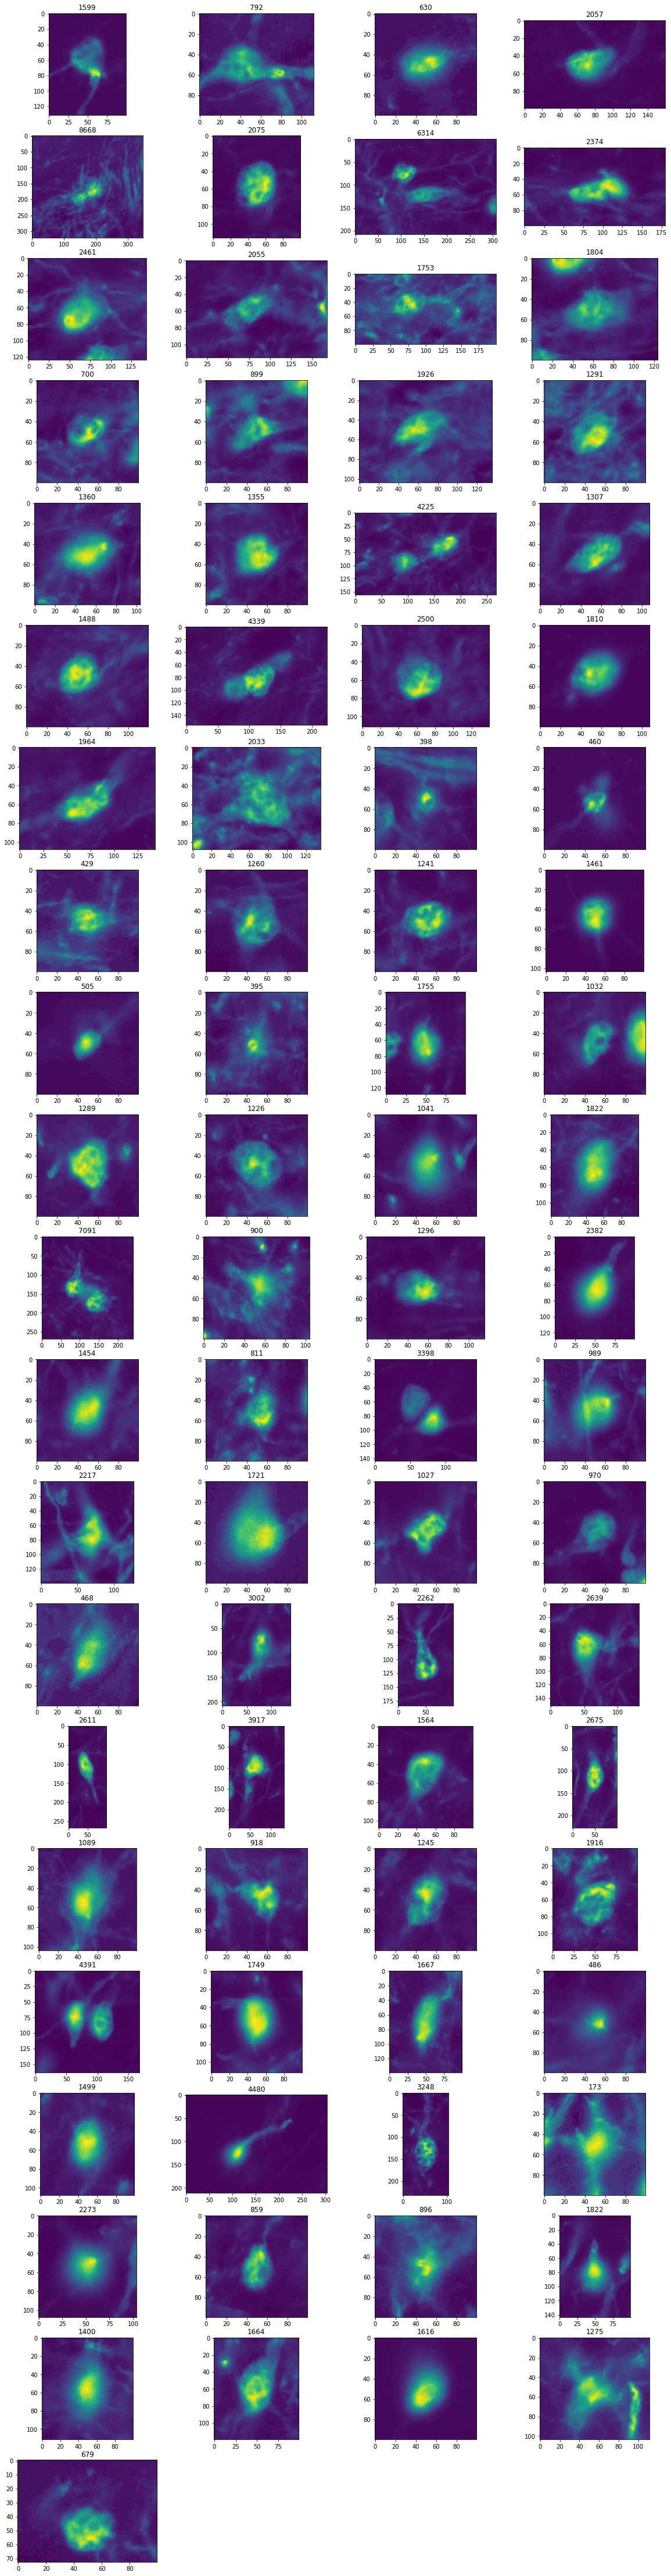

In [128]:
L=E[1][1]
print(len(L))
j=1
figure(figsize=[20,100])
for i in range(len(L)):
    if L[i]['label']==0:
        continue
    subplot(26,4,j)
    j+=1
    imshow(L[i]['image']);
    title(str(L[i]['area']))


In [129]:
# Calculate Moments
moments = cv2.moments(im)
# Calculate Hu Moments
huMoments = cv2.HuMoments(moments)

huMoments, moments

NameError: name 'im' is not defined

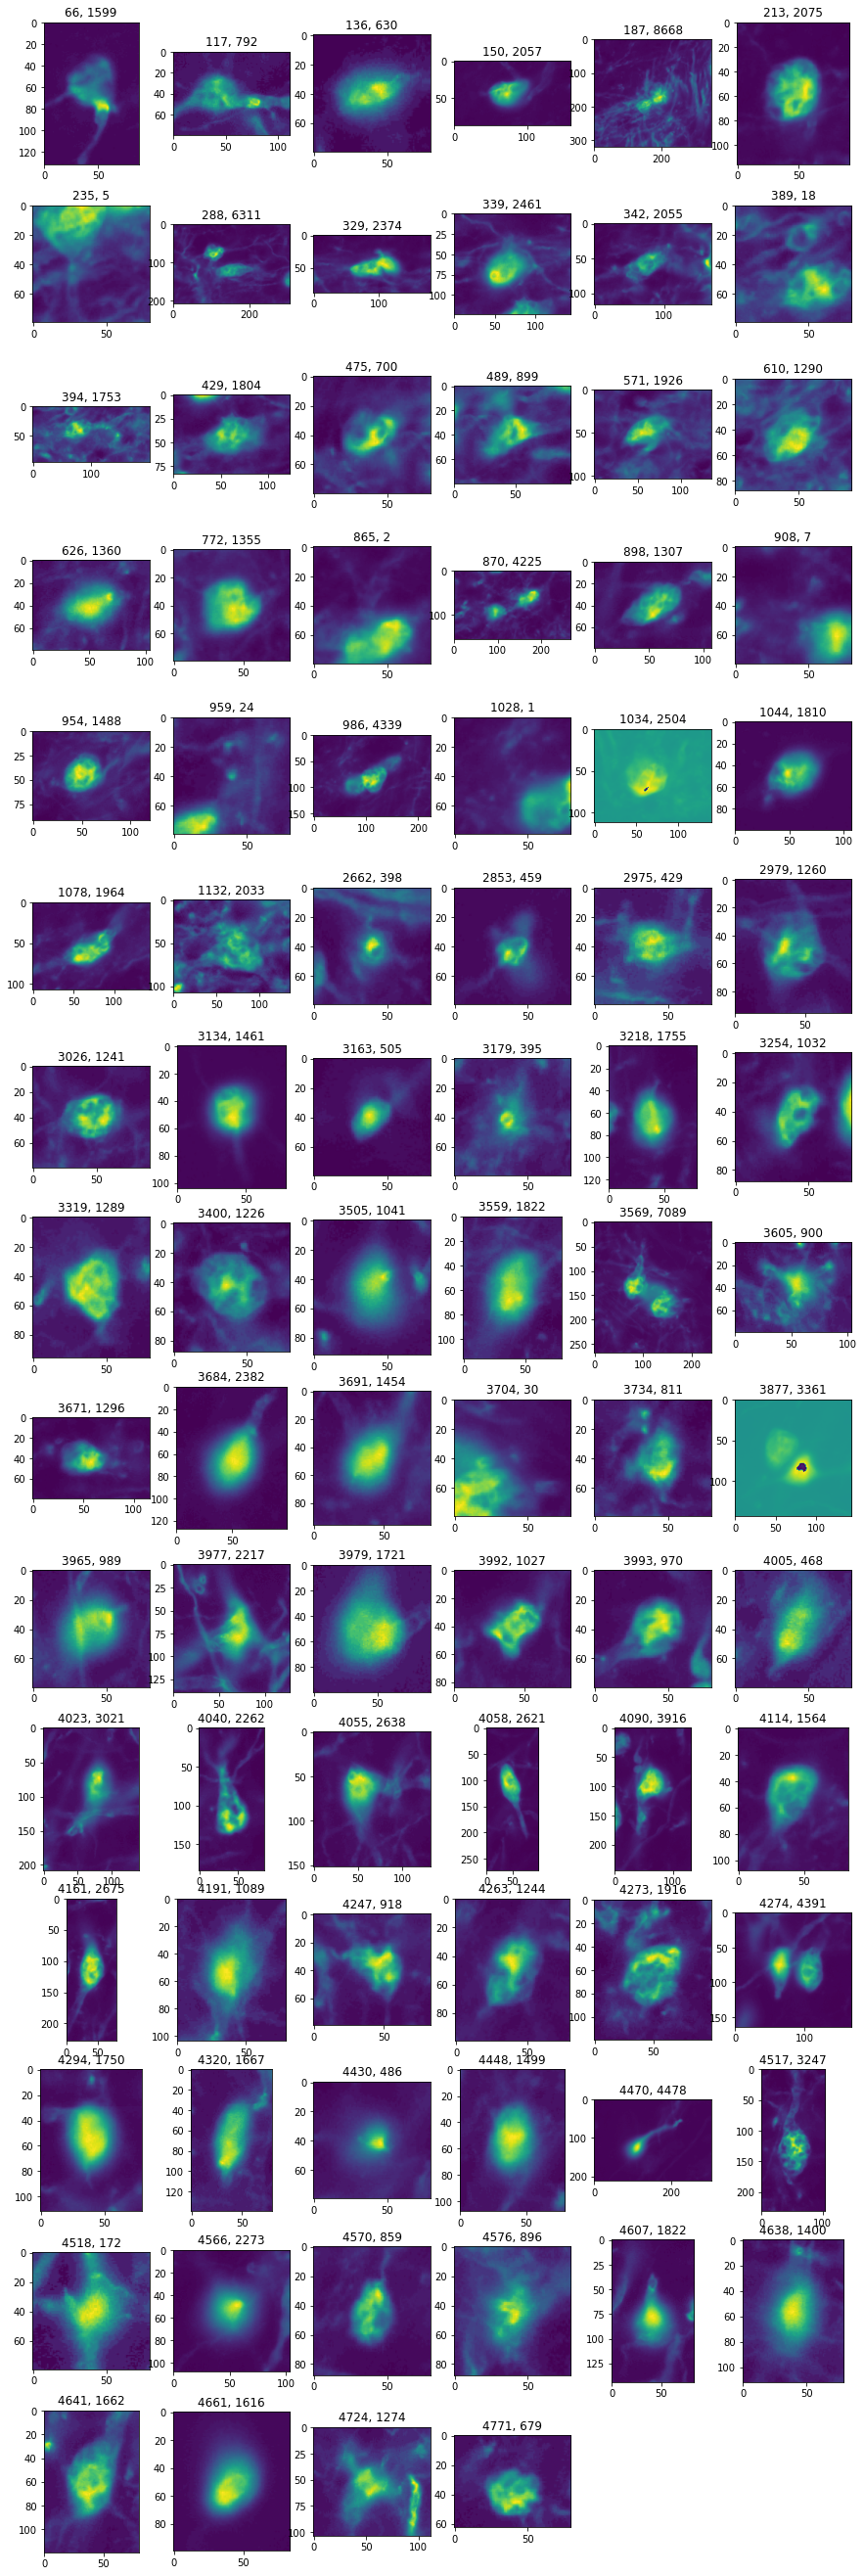

In [104]:
figure(figsize=[15,70])
i=1
for j in range(len(Examples)):
    example=Examples[j]
    if example['label']==0:
        continue
    subplot(22,6,i)
    i+=1
    imshow(example['image'])
    title('%d, %d'%(j,example['area']))


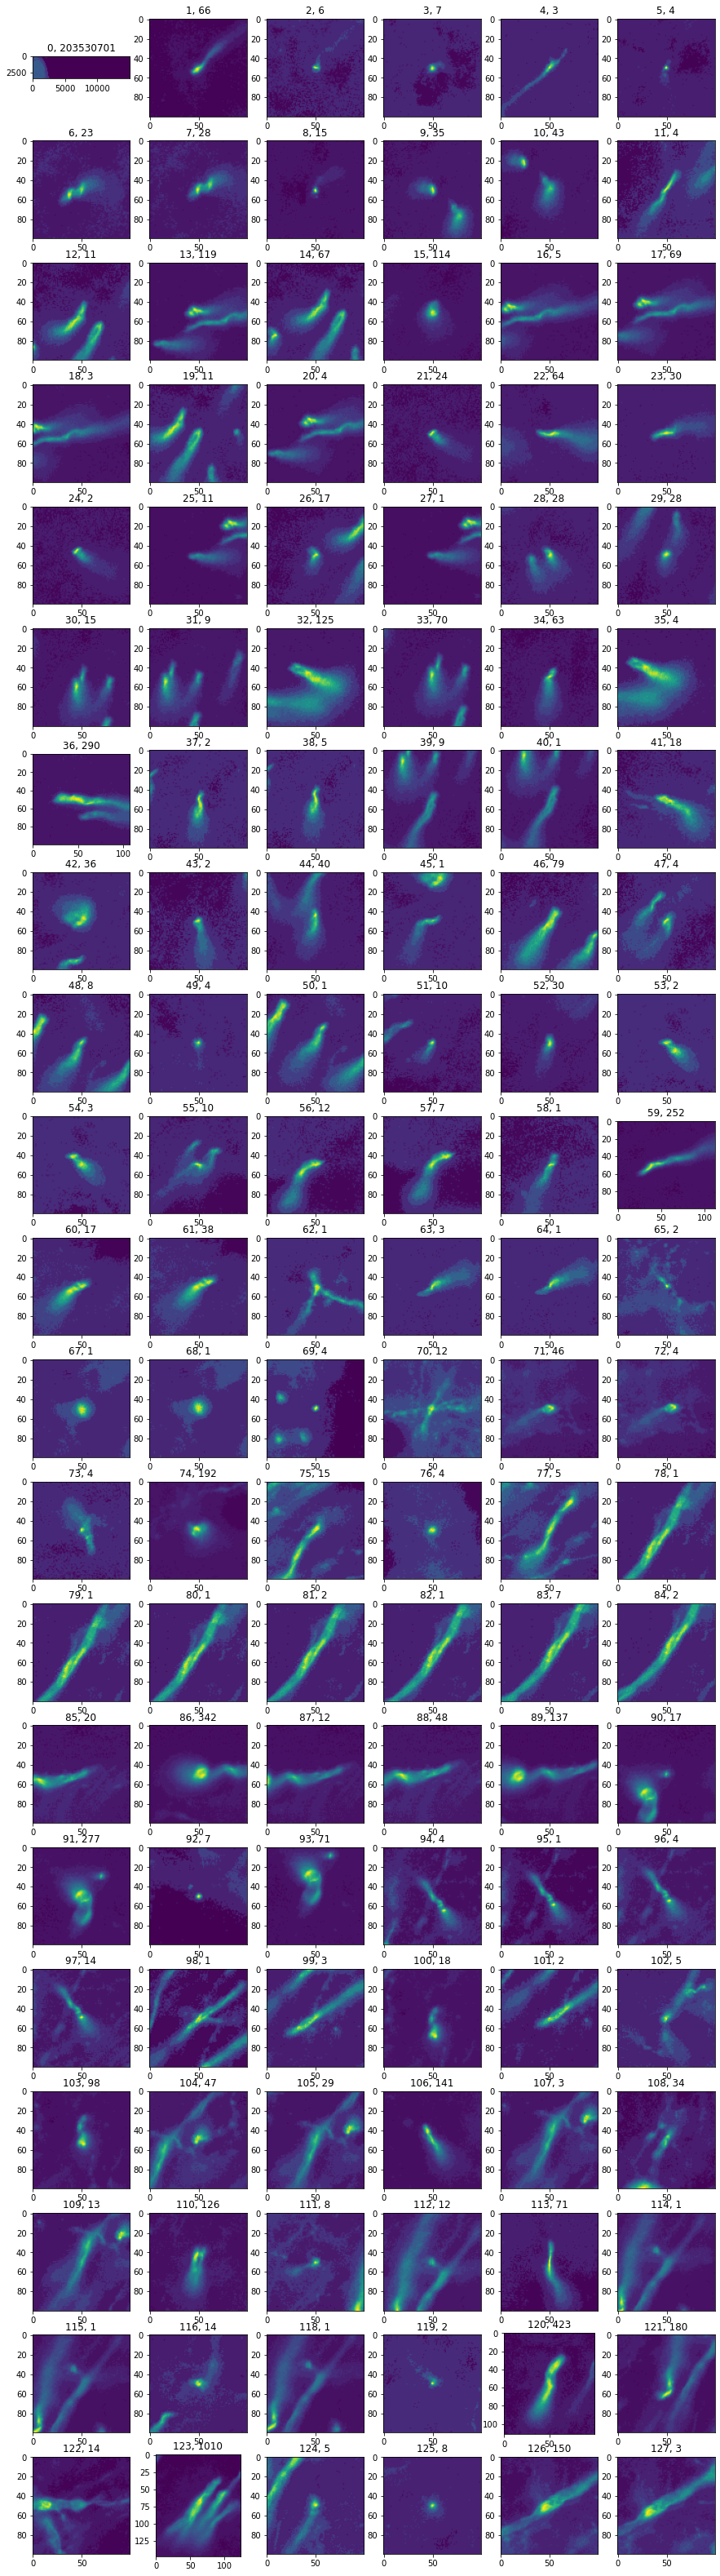

In [118]:
figure(figsize=[15,60])
i=1
Examples=E[1][1]
for j in range(len(Examples)):
    example=Examples[j]
    if example['label']==1:
        continue
    subplot(22,6,i)
    i+=1
    imshow(example['image'])
    title('%d, %d'%(j,example['area']))
    if i>21*6:
        break

